Working off of [Wesamelshamy's Image Recognition Kernel](https://www.kaggle.com/wesamelshamy/ad-image-recognition-and-quality-scoring) and using more features from OpenCV, I try to get more information from each image, like the number of colors, the kinds of colors, etc. There's a lot we can do here. Now we just have to figure out how to run it at scale for all the images and see what works in our models.

In [1]:
import os

cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Create symbolic links for trained models.
# Thanks to Lem Lordje Ko for the idea
# https://www.kaggle.com/lemonkoala/pretrained-keras-models-symlinked-not-copied
models_symlink = os.path.join(cache_dir, 'models')
if not os.path.exists(models_symlink):
    os.symlink('/kaggle/input/keras-pretrained-models/', models_symlink)

images_dir = os.path.expanduser(os.path.join('~', 'avito_images'))
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

Due to Kaggle's disk space restrictions, we will only extract a few images to classify here.  Keep in mind that the pretrained models take almost 650 MB disk space.

In [49]:
"""Extract images from Avito's advertisement image zip archive.

Code adapted from: https://www.kaggle.com/classtag/extract-avito-image-features-via-keras-vgg16/notebook
"""
import zipfile

NUM_IMAGES_TO_EXTRACT = 1000

with zipfile.ZipFile('../input/avito-demand-prediction/train_jpg.zip', 'r') as train_zip:
    files_in_zip = sorted(train_zip.namelist())
    for idx, file in enumerate(files_in_zip[:NUM_IMAGES_TO_EXTRACT]):
        if file.endswith('.jpg'):
            train_zip.extract(file, path=file.split('/')[3])

!mv *.jpg/data/competition_files/train_jpg/* ~/avito_images
!rm -rf *.jpg

In [50]:
import os

import numpy as np
import pandas as pd
from keras.preprocessing import image
import keras.applications.resnet50 as resnet50
import keras.applications.xception as xception
import keras.applications.inception_v3 as inception_v3

In [51]:
resnet_model = resnet50.ResNet50(weights='imagenet')
inception_model = inception_v3.InceptionV3(weights='imagenet')
xception_model = xception.Xception(weights='imagenet')

In [52]:
from PIL import Image
import cv2

def image_classify(model, pak, img, top_n=3):
    """Classify image and return top matches."""
    target_size = (224, 224)
    if img.size != target_size:
        img = img.resize(target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = pak.preprocess_input(x)
    preds = model.predict(x)
    return pak.decode_predictions(preds, top=top_n)[0]


def classify_and_plot(image_path):
    """Classify an image with different models.
    Plot it and its predicitons.
    """
    img = Image.open(image_path)
    resnet_preds = image_classify(resnet_model, resnet50, img)
    xception_preds = image_classify(xception_model, xception, img)
    inception_preds = image_classify(inception_model, inception_v3, img)
    cv_img = cv2.imread(image_path)
    preds_arr = [('Resnet50', resnet_preds), ('xception', xception_preds), ('Inception', inception_preds)]
    return (img, cv_img, preds_arr, image_path)

In [53]:
image_files = [x.path for x in os.scandir(images_dir)]

                                            img_path  img_size_x  img_size_y  \
0  000270561a2b0c0a6afe3dd4a3b19647dff928d681fa5b...         480         360   

   img_mean_color  img_std_color  img_blue_mean  img_green_mean  img_red_mean  \
0      136.473758       76.68472     157.984201        136.7761    114.660972   

   img_blue_std  img_green_std  img_red_std  img_Resnet50_score  \
0     68.745889      75.396757     79.32454            0.208812   

   img_xception_score  img_Inception_score img_Resnet50_label  \
0            0.838145             0.945348            minivan   

  img_xception_label img_Inception_label  
0         sports_car          sports_car  


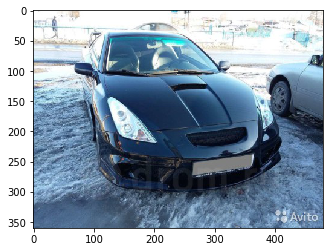

In [54]:
from collections import Counter
from pprint import pprint

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

def get_data_from_image(dat, print_img=False):
    if print_img:
        plt.imshow(dat[0])
    img_size = [dat[0].size[0], dat[0].size[1]]
    (means, stds) = cv2.meanStdDev(dat[1])
    mean_color = np.mean(dat[1].flatten())
    std_color = np.std(dat[1].flatten())
    color_stats = np.concatenate([means, stds]).flatten()
    scores = [i[1][0][2] for i in dat[2]]
    labels = [i[1][0][1] for i in dat[2]]
    img_path = dat[3].replace('/tmp/avito_images/', '').replace('.jpg', '')
    return [img_path] + img_size + [mean_color] + [std_color] + color_stats.tolist() + scores + labels

def data_to_df(data):
    df = pd.DataFrame(data,
                      columns = ['img_path', 'img_size_x', 'img_size_y', 'img_mean_color', 'img_std_color', 'img_blue_mean', 'img_green_mean', 'img_red_mean', 'img_blue_std', 'img_green_std', 'img_red_std', 'img_Resnet50_score', 'img_xception_score', 'img_Inception_score', 'img_Resnet50_label', 'img_xception_label', 'img_Inception_label'])
    return df

dat = classify_and_plot(image_files[0])
df = data_to_df([get_data_from_image(dat, print_img=True)])
print(df.head())

                                            img_path  img_size_x  img_size_y  \
0  002e4878d7b9daf0f0f0dfdc2ca944f49c20b12a3f8115...         480         360   

   img_mean_color  img_std_color  img_blue_mean  img_green_mean  img_red_mean  \
0      151.562147      84.322818     143.444369      147.598819    163.643252   

   img_blue_std  img_green_std  img_red_std  img_Resnet50_score  \
0     86.742354      85.810916    78.839739            0.544031   

   img_xception_score  img_Inception_score  img_Resnet50_label  \
0            0.726771             0.784254  cellular_telephone   

  img_xception_label img_Inception_label  
0     remote_control  cellular_telephone  
CPU times: user 3.76 s, sys: 968 ms, total: 4.73 s
Wall time: 1.22 s


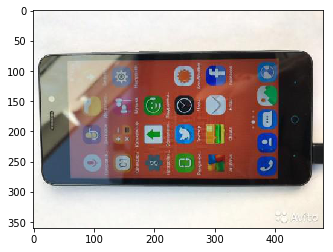

In [55]:
%%time
dat = classify_and_plot(image_files[1])
df = data_to_df([get_data_from_image(dat, print_img=True)])
print(df.head())

                                            img_path  img_size_x  img_size_y  \
0  000ac14fce25727cba366fb7584dd39ce3259c7ca917bd...         360         360   

   img_mean_color  img_std_color  img_blue_mean  img_green_mean  img_red_mean  \
0      187.657109      87.055297     185.510208       188.16037    189.300748   

   img_blue_std  img_green_std  img_red_std  img_Resnet50_score  \
0      87.99599      87.181733    85.932308            0.090653   

   img_xception_score  img_Inception_score img_Resnet50_label  \
0            0.877848             0.985611              moped   

  img_xception_label img_Inception_label  
0           tricycle             mailbag  
CPU times: user 3.83 s, sys: 876 ms, total: 4.71 s
Wall time: 1.22 s


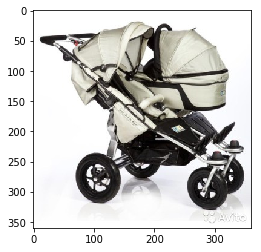

In [ ]:
%%time
dat = classify_and_plot(image_files[2])
df = data_to_df([get_data_from_image(dat, print_img=True)])
print(df.head())

In [ ]:
from tqdm import tqdm

data = []
for image_file in tqdm(image_files):
    dat = classify_and_plot(image_file)
    data += [get_data_from_image(dat)]

100%|██████████| 999/999 [20:11<00:00,  1.21s/it]


In [ ]:
train = pd.read_csv("../input/avito-demand-prediction/train.csv", parse_dates = ["activation_date"])
test = pd.read_csv("../input/avito-demand-prediction/test.csv", parse_dates = ["activation_date"])

In [ ]:
img_train = data_to_df(data)
img_train.head()

,img_path,img_size_x,img_size_y,img_mean_color,img_std_color,img_blue_mean,img_green_mean,img_red_mean,img_blue_std,img_green_std,img_red_std,img_Resnet50_score,img_xception_score,img_Inception_score,img_Resnet50_label,img_xception_label,img_Inception_label
0,000270561a2b0c0a6afe3dd4a3b19647dff928d681fa5b...,480,360,136.473758,76.684720,157.984201,136.776100,114.660972,68.745889,75.396757,79.324540,0.208812,0.838145,0.945348,minivan,sports_car,sports_car
1,002e4878d7b9daf0f0f0dfdc2ca944f49c20b12a3f8115...,480,360,151.562147,84.322818,143.444369,147.598819,163.643252,86.742354,85.810916,78.839739,0.544031,0.726771,0.784254,cellular_telephone,remote_control,cellular_telephone
2,000ac14fce25727cba366fb7584dd39ce3259c7ca917bd...,360,360,187.657109,87.055297,185.510208,188.160370,189.300748,87.995990,87.181733,85.932308,0.090653,0.877848,0.985611,moped,tricycle,mailbag
3,00241e5cc16096a1f4e40f9d970bc5c9ed6da4e3bc019f...,480,360,74.273387,59.609295,40.896065,102.007795,79.916302,43.372986,60.474691,56.624327,0.382794,0.655519,0.375732,patio,apiary,tub
4,000fbfd2bd467df826c861a7d0fd987c6f58e701d6d6d0...,360,480,34.689558,35.064839,6.378275,33.521522,64.168877,12.515834,24.964011,35.168985,0.208149,0.400286,0.595559,projector,projector,tripod


In [ ]:
img_train2 = train.merge(img_train, left_on='image', right_on='img_path')

In [ ]:
img_train2['img_size_x'].value_counts()